In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

## Question 1

In [2]:
# Copy and paste your implementations right here to check your result
# (Of course you can add your classes not written here)
def entropy(sequnence):
    """
    x : The label array
    """
    _, clsCount = np.unique(sequnence, return_counts=True)
    total = len(sequnence)
    p = clsCount / total
    log_p = np.log2(p)
    ent = -np.sum(p*log_p)
    return ent


def gini(sequnence):
    """
    x : The label array
    """
    _, clsCount = np.unique(sequnence, return_counts=True)
    total = len(sequnence)
    p = clsCount/total
    gini = np.sum(np.square(p))
    gini = 1 - gini
    return gini

In [3]:
# 1 = class 1,
# 2 = class 2
data = np.array([1,2,1,1,1,1,2,2,1,1,2])

In [4]:
print("Gini of data is ", gini(data))

Gini of data is  0.4628099173553719


In [5]:
print("Entropy of data is ", entropy(data))

Entropy of data is  0.9456603046006401


## Load data
It is a binary classifiation dataset that classify if price is high or not for a cell phone, the label is stored in `price_range` column.

In [6]:
train_df = pd.read_csv('train.csv')
val_df = pd.read_csv('val.csv')
test_df = pd.read_csv('x_test.csv')

In [7]:
feature = train_df.columns.values[:-1]
x_train = train_df.iloc[:, :-1].to_numpy()
y_train = train_df.iloc[:, -1].to_numpy()

In [8]:
x_val = val_df.iloc[:, :-1].to_numpy()
y_val = val_df.iloc[:, -1].to_numpy()

In [9]:
x_test = test_df.to_numpy()

## Question 2


In [10]:
criterionDict = {'gini': gini, 'entropy': entropy}

class Node():
    def __init__(self, feature, threshold):
        self.feature = feature
        self.threshold = threshold
        self.n_data = None
        self.metric = None
        self.lchild = None
        self.rchild = None
        self.label = None


class DecisionTree():
    def __init__(self, criterion='gini', max_depth=3):
        if max_depth is None:
            self.max_depth = np.inf
        else:
            self.max_depth = max_depth
        if self.max_depth <= 0:
            raise ValueError('Unexpected max depth')
        if self.max_depth != np.inf and type(max_depth) != int:
            raise TypeError('Max depth should be an integer.')
        self.criterion = criterionDict[criterion]
        self.depth = 0
        self.root = None
        self.n_feature = None
        self.leaflabel = []
        self.nodeFeat = []

    # Build the decision tree
    def fit(self, x, y):
        self.n_feature = len(x[0])
        featureIdx = np.arange(self.n_feature)
        self.root = self.CART_makeTree(feature=featureIdx,
                                       dataset=x, label=y, currDepth=0)

    def predict(self, x):
        y_pred = []
        for i in range(len(x)):
            xi = x[i]
            currNode = self.root
            while currNode.label is None:  # Split node
                ftIdx = currNode.feature
                if(xi[ftIdx] < currNode.threshold):
                    currNode = currNode.lchild
                else:
                    currNode = currNode.rchild
            prediction = currNode.label
            y_pred.append(prediction)
        return np.array(y_pred)

    def score(self, x, y):
        y_pred = self.predict(x)
        acc = (y_pred == y).mean()
        return acc

    def get_Feature(self, x, dataIdx):
        currNode = self.root
        while currNode.label is None:  # Split node
            ftIdx = currNode.feature
            if(x[ftIdx] < currNode.threshold):
                print(dataIdx, currNode.feature)
                currNode = currNode.lchild
            else:
                print(dataIdx, currNode.feature)
                currNode = currNode.rchild

    def decision_path(self, x):
        i = 0
        for data in x:
            self.get_Feature(data, i)
            i += 1

    def CART_makeTree(self, feature, dataset, label, currDepth):
        # Tree depth reach the max depth
        u, counts = np.unique(label, return_counts=True)

        if currDepth > self.max_depth or (len(feature)-1) <= 0:
            node = Node(feature=None, threshold=None)
            node.label = u[np.argmax(counts)]
            self.leaflabel.append(node.label)
            return node

        # The dataset of node has same classification
        elif counts[0] == len(label):
            node = Node(feature=None, threshold=None)
            node.label = u[0]
            self.leaflabel.append(node.label)
            return node

        else:
            bestFeatureIdx, nodeThresh, minGain = self.BestFeature(
                                                       feature, dataset, label)
            bestFeature = feature[bestFeatureIdx]
            self.nodeFeat.append(bestFeature)
            # The index of data which less than threshold in best feature
            l_branchIdx = np.argwhere(dataset[:, bestFeature] < nodeThresh)
            r_branchIdx = np.argwhere(dataset[:, bestFeature] >= nodeThresh)
            l_train_x = dataset[l_branchIdx].reshape(-1, self.n_feature)
            r_train_x = dataset[r_branchIdx].reshape(-1, self.n_feature)
            l_train_y = label[l_branchIdx]
            r_train_y = label[r_branchIdx]

            # Recursively build left and subtree
            if len(l_branchIdx) != 0 and len(r_branchIdx) != 0:
                # Still need to split the branch
                root = Node(bestFeature, nodeThresh)
                root.n_data = len(feature)
                root.metric = minGain
                currDepth += 1
                root.lchild = self.CART_makeTree(
                              feature, l_train_x, l_train_y, currDepth)
                root.rchild = self.CART_makeTree(
                              feature, r_train_x, r_train_y, currDepth)
                return root
            else:
                # All of data in this node are lower or higher than threshold,
                # return a leaf.
                node = Node(feature=None, threshold=None)
                node.label = u[np.argmax(counts)]
                self.leaflabel.append(node.label)
                return node

    def BestFeature(self, feature, dataset, label):
        n_data = len(dataset)
        minGain = np.inf
        bestFeatureIdx = -1
        nodeThresh = 0

        for i in feature:
            featureVals = dataset[:, i]
            # N-1 threshold
            for j in range(n_data-1):
                threshold = (featureVals[j] + featureVals[j+1])/2
                l_branchIdx = np.argwhere(featureVals < threshold)
                r_branchIdx = np.argwhere(featureVals >= threshold)
                l_branchLabel = label[l_branchIdx]
                r_branchLabel = label[r_branchIdx]
                l_branch_w = len(l_branchIdx) / n_data
                r_branch_w = len(r_branchIdx) / n_data
                # The impurity after spilt
                gain = l_branch_w * self.criterion(l_branchLabel)
                gain += r_branch_w * self.criterion(r_branchLabel)
                if gain < minGain:
                    minGain = gain
                    bestFeatureIdx = np.argwhere(feature == i).item(0)
                    nodeThresh = threshold

        return bestFeatureIdx, nodeThresh, minGain

### Question 2.1
Using `criterion=gini`, showing the accuracy score of validation data by `max_depth=3` and `max_depth=10`, respectively.

In [11]:
clf_depth3 = DecisionTree(criterion='gini', max_depth=3)
clf_depth10 = DecisionTree(criterion='gini', max_depth=10)

In [12]:
clf_depth3.fit(x=x_train, y=y_train)
clf_depth3.score(x=x_val, y=y_val)

0.9433333333333334

In [13]:
clf_depth10.fit(x=x_train, y=y_train)
clf_depth10.score(x=x_val, y=y_val)

0.95

### Question 2.2
Using `max_depth=3`, showing the accuracy score of validation data by `criterion=gini` and `criterion=entropy`, respectively.

In [14]:
clf_gini = DecisionTree(criterion='gini', max_depth=3)
clf_gini.fit(x=x_train, y=y_train)
clf_gini.score(x=x_val, y=y_val)

0.9433333333333334

In [15]:
clf_entropy = DecisionTree(criterion='entropy', max_depth=3)
clf_entropy.fit(x=x_train, y=y_train)
clf_entropy.score(x=x_val, y=y_val)

0.94

- Note: Your decisition tree scores should over **0.9**. It may suffer from overfitting, if so, you can tune the hyperparameter such as `max_depth`
- Note: You should get the same results when re-building the model with the same arguments,  no need to prune the trees
- Hint: You can use the recursive method to build the nodes

## Question 3
Plot the [feature importance](https://sefiks.com/2020/04/06/feature-importance-in-decision-trees/) of your Decision Tree model. You can get the feature importance by counting the feature used for splitting data.

- You can simply plot the **counts of feature used** for building tree without normalize the importance. Take the figure below as example, outlook feature has been used for splitting for almost 50 times. Therefore, it has the largest importance

![image](https://i2.wp.com/sefiks.com/wp-content/uploads/2020/04/c45-fi-results.jpg?w=481&ssl=1)

In [15]:
featIdx, n_show = np.unique(clf_depth10.nodeFeat, return_counts=True)
selectedFeature = feature[featIdx]

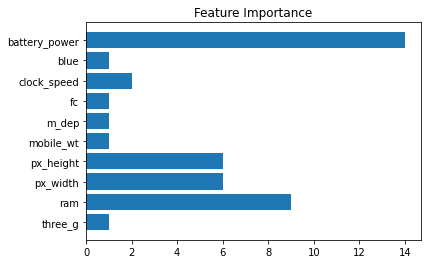

In [16]:
fig, ax = plt.subplots()
y_pos = np.arange(len(selectedFeature))
ax.barh(y_pos, n_show, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(selectedFeature)
ax.invert_yaxis()
ax.set_title('Feature Importance')
plt.show()

## Question 4

In [16]:
class AdaBoost():
    def __init__(self, n_estimators,
                criterion='gini', max_depth=1):
        self.n_estimators = n_estimators
        self.criterion = criterion
        self.max_depth = max_depth
        self.alpha_list = []
        self.weakLearner = []
        
    def weakResult(self, clf, x, y):
        y_pred = clf.predict(x)
        err_list = (y_pred != y).astype(int).reshape(-1,1)
        return err_list, y_pred.reshape(-1,1)
    
    def getWeakLearner(self, x, y, weights):
        w_min = weights.min()
        new_X = (weights*x)/w_min
        weakclf = DecisionTree(criterion=self.criterion,
                               max_depth=self.max_depth)
        weakclf.fit(new_X, y)
        err_list, pred_list = self.weakResult(weakclf, x, y)
        err_w = (weights.T@err_list)[0,0] # weighted error
        return weakclf, pred_list, err_w

    def fit(self, x, y):
        y[y == 0] = -1
        n_data = x.shape[0]
        weights = (np.ones(n_data) / n_data).reshape(-1, 1)
        for i in range(self.n_estimators):
            # get new weak learner
            weakclf, pred_list, error = self.getWeakLearner(x, y, weights)
            alpha = 0.5*np.log((1-error)/max(error, 1e-8))
            # Update weights
            self.weakLearner.append(weakclf)
            self.alpha_list.append(alpha)
            weights = weights*np.exp(-1*alpha*y.reshape(-1,1)*pred_list) 
            weights = weights/weights.sum()
        y[y == -1] = 0

    def predict(self, x):
        y_pred = np.zeros(len(x))
        for i in range(self.n_estimators):
            y_pred += self.alpha_list[i] * self.weakLearner[i].predict(x)
        return np.sign(y_pred)

    def score(self, x, y):
        y_pred = self.predict(x)
        y_pred[y_pred == -1] = 0
        acc = (y_pred == y).mean()
        return acc

### Question 4.1
Show the accuracy score of validation data by `n_estimators=10` and `n_estimators=100`, respectively.


In [12]:
AB_10tree = AdaBoost(n_estimators=10)
AB_10tree.fit(x_train, y_train)
AB_10tree.score(x_val, y_val)

0.8933333333333333

In [13]:
AB_100tree = AdaBoost(n_estimators=100)
AB_100tree.fit(x_train, y_train)
AB_100tree.score(x_val, y_val)

0.8933333333333333

## Question 5
implement the Random Forest algorithm by using the CART you just implemented from question 2. You should implement three arguments for the Random Forest.

1. **n_estimators**: The number of trees in the forest. 
2. **max_features**: The number of random select features to consider when looking for the best split
3. **bootstrap**: Whether bootstrap samples are used when building tree

In [17]:
class RandomForest():
    def __init__(self, n_estimators, max_features,
                 criterion='gini', max_depth=None, bootstrap=True):
        self.n_estimators = n_estimators
        self.max_feature = int(max_features)
        self.max_depth = max_depth
        self.criterion = criterion
        self.bootstrap = bootstrap
        self.forest = []
        self.selectedFeature = []
        self.n_dataPerTree = None

    def fit(self, x, y):
        if not self.bootstrap:
            self.n_dataPerTree = int(len(x)/self.n_estimators)
        n_features = x.shape[1]
        featureIdx = np.arange(n_features)
        for i in range(self.n_estimators):
            # Randomly pick feature
            ft_subset = featureIdx.copy()
            np.random.shuffle(ft_subset)
            ft_subset = ft_subset[:self.max_feature]
            self.selectedFeature.append(ft_subset)
            # abstract corresponding data
            new_x = x[:, ft_subset]
            if not self.bootstrap:
                n_data = len(x)
                new_dataIdx = np.arange(n_data)
                np.random.shuffle(new_dataIdx)
                new_dataIdx = new_dataIdx[:self.n_dataPerTree]
                new_x = new_x[new_dataIdx]
                x = np.delete(x, new_dataIdx)
            # Add a tree into forest
            clf = DecisionTree(criterion=self.criterion,
                               max_depth=self.max_depth)
            clf.fit(new_x, y)
            self.forest.append(clf)

    def predict(self, x):
        y_pred_all = []
        n_test = len(x)
        for i in range(self.n_estimators):
            data_sf = x[:, self.selectedFeature[i]]
            # predicted label of a certain tree
            y_pred_e = self.forest[i].predict(data_sf)
            y_pred_all.append(y_pred_e)
        # Decide label by majority count
        y_pred_all = np.array(y_pred_all)
        y_pred = []
        for i in range(n_test):
            u, c = np.unique(y_pred_all[:, i], return_counts=True)
            pred_label_f = u[np.argmax(c)]
            y_pred.append(pred_label_f)
        return np.array(y_pred)

    def score(self, x, y):
        y_pred = self.predict(x)
        acc = (y_pred == y).mean()
        return acc

### Question 5.1
Using `criterion=gini`, `max_depth=None`, `max_features=sqrt(n_features)`, showing the accuracy score of validation data by `n_estimators=10` and `n_estimators=100`, respectively.


In [23]:
clf_10tree = RandomForest(n_estimators=10, max_features=int(np.sqrt(x_train.shape[1])))
clf_10tree.fit(x_train, y_train)
clf_10tree.score(x_val, y_val)

0.61

In [19]:
clf_100tree = RandomForest(n_estimators=100, max_features=int(np.sqrt(x_train.shape[1])))
clf_100tree.fit(x_train, y_train)
clf_100tree.score(x_val, y_val)

0.8666666666666667

### Question 5.2
Using `criterion=gini`, `max_depth=None`, `n_estimators=10`, showing the accuracy score of validation data by `max_features=sqrt(n_features)` and `max_features=n_features`, respectively.


In [20]:
clf_random_features = RandomForest(n_estimators=10, max_features=int(np.sqrt(x_train.shape[1])))
clf_random_features.fit(x_train, y_train)
clf_random_features.score(x_val, y_val)

0.64

In [21]:
clf_all_features = RandomForest(n_estimators=10, max_features=x_train.shape[1])
clf_all_features.fit(x_train, y_train)
clf_all_features.score(x_val, y_val)

0.9566666666666667

### Question 6. Train and tune your model on a real-world dataset
Try you best to get higher accuracy score of your model. After parameter tuning, you can train your model on the full dataset (train + val).
- Feature engineering
- Hyperparameter tuning
- Implement any other ensemble methods, such as gradient boosting. Please note that you **can not** call any package. Also, only ensemble method can be used. Neural network method is not allowed to used.

In [25]:
def train_your_model(data):
    ## Define your model and training
    x_train = data.iloc[:, :-1].to_numpy()
    y_train = data.iloc[:, -1].to_numpy()
    model = RandomForest(n_estimators=10, max_features=x_train.shape[1])
    model.fit(x_train, y_train)
    return model

In [26]:
train_df = pd.concat([pd.read_csv('train.csv'), pd.read_csv('val.csv')])
my_model = train_your_model(train_df)
my_model.score(x_val, y_val) 

1.0

In [27]:
y_pred = my_model.predict(x_test)

In [39]:
assert y_pred.shape == (500, )

## Supplementary
If you have trouble to implement this homework, TA strongly recommend watching [this video](https://www.youtube.com/watch?v=LDRbO9a6XPU), which explains Decision Tree model clearly. But don't copy code from any resources, try to finish this homework by yourself! 

### DO NOT MODIFY CODE BELOW

In [29]:
import pandas as pd
from sklearn.metrics import accuracy_score
y_test = pd.read_csv('y_test.csv')['price_range'].values

print('Test-set accuarcy score: ', accuracy_score(y_test, y_pred))

FileNotFoundError: [Errno 2] File y_test.csv does not exist: 'y_test.csv'

In [30]:
def discrete_checker(score, thres, clf, name, x_train, y_train, x_test, y_test):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    if accuracy_score(y_test, y_pred) - thres >= 0:
        return score
    else:
        print(f"{name} failed")
        return 0


def patient_checker(score, thres, CLS, kwargs, name,
                    x_train, y_train, x_test, y_test, patient=10):
    while patient > 0:
        patient -= 1
        clf = CLS(**kwargs)
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        if accuracy_score(y_test, y_pred) - thres >= 0:
            return score
    print(f"{name} failed")
    print("Considering the randomness, we will check it manually")
    return 0


def load_dataset():
    file_url = "http://storage.googleapis.com/download.tensorflow.org/data/abalone_train.csv"
    df = pd.read_csv(
        file_url,
        names=["Length", "Diameter", "Height", "Whole weight", "Shucked weight",
               "Viscera weight", "Shell weight", "Age"]
    )

    df['Target'] = (df["Age"] > 15).astype(int)
    df = df.drop(labels=["Age"], axis="columns")

    train_idx = range(0, len(df), 10)
    test_idx = range(1, len(df), 20)

    train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]

    x_train = train_df.drop(labels=["Target"], axis="columns")
    feature_names = x_train.columns.values
    x_train = x_train.values
    y_train = train_df['Target'].values

    x_test = test_df.drop(labels=["Target"], axis="columns")
    x_test = x_test.values
    y_test = test_df['Target'].values
    return x_train, y_train, x_test, y_test, feature_names

score = 0

data = np.array([1, 2])
if abs(gini(data) - 0.5) < 1e-4:
    score += 2.5
else:
    print("gini test failed")

if abs(entropy(data) - 1) < 1e-4:
    score += 2.5
else:
    print("entropy test failed")

x_train, y_train, x_test, y_test, feature_names = load_dataset()

score += discrete_checker(5, 0.9337,
                          DecisionTree(criterion='gini', max_depth=3),
                          "DecisionTree(criterion='gini', max_depth=3)",
                          x_train, y_train, x_test, y_test
                          )

score += discrete_checker(2.5, 0.9036,
                          DecisionTree(criterion='gini', max_depth=10),
                          "DecisionTree(criterion='gini', max_depth=10)",
                          x_train, y_train, x_test, y_test
                          )

score += discrete_checker(2.5, 0.9096,
                          DecisionTree(criterion='entropy', max_depth=3),
                          "DecisionTree(criterion='entropy', max_depth=3)",
                          x_train, y_train, x_test, y_test
                          )

print("*** We will check your result for Question 3 manually *** (5 points)")

score += patient_checker(
    7.5, 0.91, AdaBoost, {"n_estimators": 10},
    "AdaBoost(n_estimators=10)",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    7.5, 0.87, AdaBoost, {"n_estimators": 100},
    "AdaBoost(n_estimators=100)",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.91, RandomForest,
    {"n_estimators": 10, "max_features": np.sqrt(x_train.shape[1])},
    "RandomForest(n_estimators=10, max_features=sqrt(n_features))",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.91, RandomForest,
    {"n_estimators": 100, "max_features": np.sqrt(x_train.shape[1])},
    "RandomForest(n_estimators=100, max_features=sqrt(n_features))",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.92, RandomForest,
    {"n_estimators": 10, "max_features": x_train.shape[1]},
    "RandomForest(n_estimators=10, max_features=n_features)",
    x_train, y_train, x_test, y_test
)

print("*** We will check your result for Question 6 manually *** (20 points)")
print("Approximate score range:", score, "~", score + 25)
print("*** This score is only for reference ***")


DecisionTree(criterion='gini', max_depth=3) failed
*** We will check your result for Question 3 manually *** (5 points)
AdaBoost(n_estimators=10) failed
Considering the randomness, we will check it manually
AdaBoost(n_estimators=100) failed
Considering the randomness, we will check it manually
*** We will check your result for Question 6 manually *** (20 points)
Approximate score range: 25.0 ~ 50.0
*** This score is only for reference ***
